In [28]:
import sys; sys.path.insert(0, '..')

In [29]:
import pandas as pd
from tqdm import notebook
from utils.regex_fx import remove_mention, remove_non_ascii, remove_emojis, remove_urls, remove_nonalpha, remove_extra_spaces, remove_special_words, remove_rt, remove_single_char, remove_numbers
import spacy
import re
import numpy as np
nlp = spacy.load("en_core_web_sm")
from gensim.models import LdaMulticore, Phrases
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from collections import Counter

import itertools
from fuzzywuzzy import fuzz

In [30]:
def cleanup(text):
    res = remove_mention(text)
    res = remove_non_ascii(res)
    res = res.lower()
    res = remove_urls(res)
    res = remove_rt(res)
    res = remove_single_char(res)
    res = remove_numbers(res)
    res = remove_emojis(res)
    res = remove_nonalpha(res)
    res = remove_extra_spaces(res)
    res = remove_special_words(res)
    return res

In [31]:
fake = pd.read_csv('fake.csv')
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78502 entries, 0 to 78501
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    78502 non-null  int64  
 1   Unnamed: 0.1  78502 non-null  object 
 2   created_at    78502 non-null  object 
 3   text          78502 non-null  object 
 4   author_id     78500 non-null  object 
 5   id            78498 non-null  float64
 6   news_id       78498 non-null  object 
 7   withheld      7 non-null      object 
dtypes: float64(1), int64(1), object(6)
memory usage: 4.8+ MB
/Users/vangelistrikoupis/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (1,4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [32]:
real = pd.read_csv('real.csv')

In [33]:
real_cleaned = []
for item in real.text.to_list():
    real_cleaned.append(cleanup(item))
real.text = real_cleaned

In [34]:
fake_cleaned = []
for item in fake.text.to_list():
    fake_cleaned.append(cleanup(item))
fake.text = fake_cleaned

In [161]:
processedRealStrings = []
matchers = []

for real in real_cleaned:
    if real:
        processedClean = fuzz._process_and_sort(real, True, True)
        processedRealStrings.append({"processed": processedClean, "string": real})

processedRealStrings.sort(key= lambda x: len(x["processed"]))

for idx, real in notebook.tqdm(enumerate(processedRealStrings)):
    length = len(real["processed"])
    matcher = fuzz.SequenceMatcher(None, real["processed"])
    for idx2 in range(idx + 1, len(processedRealStrings)):
        real2 = processedRealStrings[idx2]
        if 2 * length / (length + len(real2["processed"])) < 0.8: # upper bound
            break

        matcher.set_seq2(real2["processed"])

        if matcher.quick_ratio() >= 0.8: # should also try without quick_ratio() check
            # print(real["string"], real2["string"])
            processedRealStrings.remove(real2)

In [11]:
# politifact_fake = pd.read_csv('../fakenewsnet/politifact_fake.csv')
# politifact_real = pd.read_csv('../fakenewsnet/politifact_real.csv')

# politifact_real_cleaned = []
# for item in politifact_real.title.to_list():
#     politifact_real_cleaned.append(cleanup(item))
# politifact_real.title = politifact_real_cleaned


# politifact_fake_cleaned = []
# for item in politifact_fake.title.to_list():
#     politifact_fake_cleaned.append(cleanup(item))
# politifact_fake.title = politifact_fake_cleaned

# text_list = politifact_fake.title.to_list() + politifact_real.title.to_list()

In [276]:
processedFakeStrings = []
matchers = []

for fake in fake_cleaned:
    if fake:
        processedClean = fuzz._process_and_sort(fake, True, True)
        processedFakeStrings.append({"processed": processedClean, "string": fake})

processedFakeStrings.sort(key= lambda x: len(x["processed"]))

for idx, fake in notebook.tqdm(enumerate(processedFakeStrings)):
    length = len(fake["processed"])
    matcher = fuzz.SequenceMatcher(None, fake["processed"])
    for idx2 in range(idx + 1, len(processedFakeStrings)):
        fake2 = processedFakeStrings[idx2]
        if 2 * length / (length + len(fake2["processed"])) < 0.85: # upper bound
            break

        matcher.set_seq2(fake2["processed"])

        if matcher.quick_ratio() >= 0.85: # should also try without quick_ratio() check
            processedFakeStrings.remove(fake2)

0it [00:00, ?it/s]

IndexError: list index out of range

In [283]:
import random

In [288]:
string_array = []
real_string_array = []
for item in processedFakeStrings:
    if len(item['string']) > 100:
        string_array.append(item['string'])
print(len(string_array))
# a lot less fake than real, pick this many random from the real:
for item in processedStrings:
    if len(item['string']) > 100:
        real_string_array.append(item['string'])
real_sample = random.sample(real_string_array, len(string_array))
string_array += real_sample

18472


In [291]:
np.save('over_100_non_duplicate', string_array)

In [82]:
np.save('real_over_100_non_duplicate', real_string_array)

In [43]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).quick_ratio()

In [9]:
i=0
counter=10
if i < counter:
    fake.reset_index(drop=True, inplace=True)
    for index, item in notebook.tqdm(fake.iterrows()):
        if index < len(fake)-1:
            if similar(fake.loc[index,'text'], fake.loc[index+1,'text']) > 0.90:
                fake.drop(index, inplace = True)
    real.reset_index(drop=True, inplace=True)
    for index, item in notebook.tqdm(real.iterrows()):
        if index < len(real)-1:
            if similar(real.loc[index,'text'], real.loc[index+1,'text']) > 0.90:
                real.drop(index, inplace = True)
    i+=1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [363]:
real = real.drop_duplicates(subset=['text'], keep='first')
real = real.sort_values('text')
real = real[real.text.notnull()]
real = real[real.text != ""]
real = real[real.text.str.len() > 100]
real_subset = real.groupby('news_id').apply(lambda x: x.sample(frac=0.152459))
# real_subset = real.groupby('news_id').apply(lambda x: x.sample(frac=0.147625))
# real_subset = real.groupby('news_id').apply(lambda x: x.sample(frac=0.106594))
real_subset

Unnamed: 0            id  \
news_id                                            
politifact10185 127076      132579  9.668240e+17   
                94221        98496  8.924622e+17   
                169686      177400  1.005915e+18   
                123917      129278  2.952833e+10   
                160695      167924  9.570065e+17   
...                            ...           ...   
politifact99    189962      198845  8.879394e+17   
                116348      121270  8.181896e+17   
                150962      157735  8.746834e+17   
                88099        92236  9.227166e+17   
                113352      118174  9.936822e+17   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              text  \
news_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
politifact10185 127076  orangesforpeace nycnash leftwardswing rawideasinc todmoore3 alaynasmother kavn bswhistler gdnghtaltrght boxings007 liberalncali pureh2 bookishboredom hiyajazz ayilfukuup mobygrapefan factchek realaltperson stopwithurbs naninkansas dschwertfege veggie64leslie loraleatucker markitgeek damnpamfromnamm steelbreezes dougdooganuchi my2meows linesonly poohsbrana joemon49 steveschmitz2 blysx punksandwitch carlothecommie demonicalien pa1lauren sensanders justicedems brandnew535 thedemocrats intelligencer jst watched ari on msnbc title of bernie backpedaling hrc camp rep bernie camp rep hrc rep said no not saying russ helped bernie but bernie quiet abt russ cause like wld lose effect of his accomplishments bernie guy sd this is not blame game he had informed hrc   
                94221                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 kylekulinski when the democrats lose again will they blame the bernie wing again rofl these guys suck so bad   
                169686                                                                                                                                                                     

In [352]:
fake = fake.drop_duplicates(subset=['text'], keep='first')
fake = fake.sort_values('text')
fake = fake[fake.text.notnull()]
fake = fake[fake.text != ""]
fake = fake[fake.text.str.len() > 100]
fake_subset = fake.groupby('news_id').apply(lambda x: x.sample(frac=1))
fake_subset

Unnamed: 0 Unnamed: 0.1                created_at  \
news_id                                                                    
politifact13496 42288       42288        42287  2016-11-25T20:26:16.000Z   
                42322       42322        42321  2016-11-25T20:30:24.000Z   
                42323       42323        42322  2016-11-25T20:30:24.000Z   
                42768       42768        42766  2016-11-27T03:40:51.000Z   
politifact13515 35848       35848        35848  2018-02-15T22:01:01.000Z   
...                           ...          ...                       ...   
politifact15631 36259       36259        36259  2018-08-10T12:52:23.000Z   
                36231       36231        36231  2018-07-20T16:03:49.000Z   
                36156       36156        36156  2018-07-18T19:12:30.000Z   
                36206       36206        36206  2018-07-19T15:21:00.000Z   
                36220       36220        36220  2018-07-20T03:44:33.000Z   

                                                                                                                                                                                                                                                   text  \
news_id                                                                                                                                                                                                                                                   
politifact13496 42288                                                                                                          the cnn porn scare is how fake spreads wnn2 last night twitter account by the name of solikearose tweeted out surprising   
                42322                                                                                                                           the cnn porn scare is how fake spreads last night twitter account by the name of tweeted out surprising   
                42323                                                                                                                  the cnn porn scare is how fake spreads last night twitter account by the name of tweeted out surprising image of   
                42768                                                                                                                           lol think before you react to anything on social media the cnn porn scare is how fake spreads the verge   
politifact13515 35848               inbox endorses for ag commissioner brutalizes incumbent sid millers shortcomings are all about the job he was hired at the ballot box to do for the people of texas in that job sid miller has failed tx2018 txlege   
...                                                                                                                                                                                                                                                 ...   
politifact15631 36259                                   lisa page squeals dnc server was not hacked by russia well well well look what we have here the chinese did it not russia then we have feinstein chinese driver who was recently exposed as spy   
                36231     page says it was china not russia who hacked the dnchow about the truth it was the fbi who hacked the dnc if anyone didit could all be another hillary clinton lie to cover her tracks of the many felonies she has committed   
                36156                                                                                                      yet foreced to russia russia russia so the fake narrative continueslisa page squeals dnc server was not hacked by russia via   
                36206  its all far from over yet but an old proverb share by college professor many years ago remains true the wheels of justice grind slowly but they grind exceedingly fine lisa page squeals dnc server was not hacked by russia via   
                36220 

In [368]:
combined = fake_subset.append(real_subset)
# combined = real

In [369]:
text_list = combined.text
text_list = text_list.tolist()


In [370]:
# text_list = string_array

In [371]:
processed_texts = [text for text in notebook.tqdm(nlp.pipe(text_list, 
                                                n_process=-1, # maximum number of threads
                                                disable=["ner", "parser"]),
                                                total=len(text_list))]

  0%|          | 0/40056 [00:00<?, ?it/s]

In [372]:
allow_postags = set(['NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN'])

In [373]:
# tokenized_texts = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] for lemma_ in notebook.tqdm(processed_texts)]
tokenized_texts = [[word.lemma_ for word in lemma_  if word.pos_ in allow_postags  if not word.is_punct if not word.is_stop] for lemma_ in notebook.tqdm(processed_texts)]


  0%|          | 0/40056 [00:00<?, ?it/s]

In [386]:
rmv = ['house', 'america', 'representative', 'wakeupamerica', 'wake', 'fox', 'foxnew', 'foxnews', 'amp', 'de', 'cnn', 'm', 've', 'nt', 's', ]
tokenized_texts = [[i for i in nested if i not in rmv ] for nested in tokenized_texts]

In [387]:
def make_n_grams(docs):
    # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(docs, min_count=1)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)
    return docs

In [388]:
def process_tokenized(tokenized_texts):
    # tokenized_texts = make_n_grams(tokenized_texts)
    flatten = lambda t: [item for sublist in t for item in sublist]
    flattened = flatten(tokenized_texts)
    counts = Counter(flattened)
    total_words = sum(counts.values()) 
    for word in counts:
        counts[word] = counts[word] #* (10000) / total_words
    return counts, counts.most_common(), flattened, tokenized_texts

In [389]:
tokenized_obj = process_tokenized(tokenized_texts)
counts_combined, common_combined, flattened_combined, tokenized_texts_combined = tokenized_obj

In [390]:
common_combined[:100]

[('state', 3673),
 ('president', 3369),
 ('people', 3225),
 ('vote', 2604),
 ('say', 2441),
 ('interview', 2309),
 ('time', 2251),
 ('federal', 2131),
 ('know', 2066),
 ('need', 2048),
 ('go', 1904),
 ('republican', 1860),
 ('american', 1809),
 ('day', 1800),
 ('statement', 1754),
 ('right', 1721),
 ('want', 1706),
 ('think', 1657),
 ('good', 1643),
 ('senate', 1614),
 ('regulation', 1539),
 ('nation', 1535),
 ('speech', 1527),
 ('code', 1517),
 ('today', 1480),
 ('country', 1465),
 ('control', 1462),
 ('white', 1441),
 ('get', 1417),
 ('come', 1384),
 ('work', 1370),
 ('election', 1341),
 ('watch', 1304),
 ('great', 1296),
 ('congress', 1255),
 ('video', 1245),
 ('national', 1231),
 ('look', 1204),
 ('woman', 1185),
 ('union', 1169),
 ('year', 1165),
 ('member', 1150),
 ('week', 1129),
 ('face', 1121),
 ('lie', 1116),
 ('meet', 1104),
 ('bill', 1074),
 ('let', 1073),
 ('world', 1059),
 ('way', 1042),
 ('tell', 1042),
 ('press', 1024),
 ('law', 1015),
 ('report', 1007),
 ('support', 10

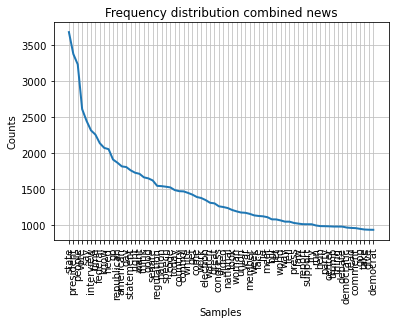

<AxesSubplot:title={'center':'Frequency distribution combined news'}, xlabel='Samples', ylabel='Counts'>

In [391]:
import nltk
from nltk import FreqDist
fdist_filtered = FreqDist(counts_combined)
fdist_filtered.plot(70,title='Frequency distribution combined news')

In [392]:
def compute_coherence_values(texts, start, step, limit, topn):
    dictionary = Dictionary(texts) # get the vocabulary
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    coherence_values = []
    model_list = []
    for num_topics in notebook.tqdm(range(start, limit, step)):
        model = LdaMulticore( corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha = 0.1, iterations = 1000)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v', topn=topn)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [393]:
# model_list, coherence_values = compute_coherence_values(texts=tokenized_texts, start=1, step=1, limit= 40, topn=5)

In [382]:
all_scores = []
for n in range(5, 15, 5):
    model_list, coherence_values = compute_coherence_values(texts=tokenized_texts, start=1, step=1, limit=40, topn=n)
    all_scores.append(coherence_values)

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

In [383]:
all_scores = np.array(all_scores)
avg_scores = np.average(all_scores, axis=0)
print(avg_scores)

[0.07201919 0.17380311 0.1635492  0.21023208 0.24808979 0.22872293
 0.23599421 0.24197419 0.26060651 0.24963468 0.27337061 0.25891453
 0.26647577 0.25869818 0.29963088 0.2936767  0.28086818 0.32442652
 0.29859675 0.29786961 0.29475262 0.31675871 0.29095622 0.29946568
 0.34265309 0.29531434 0.30714372 0.30063106 0.31767788 0.30772075
 0.32076094 0.30486107 0.30352884 0.32899157 0.30754543 0.31401086
 0.30680305 0.31814228 0.32290753]


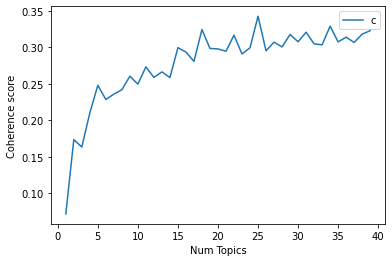

In [384]:
# Show graph
import matplotlib.pyplot as plt
limit=40; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, avg_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [329]:
def topic_modelling_results(tokenized_text, n_topics, n_iterations):
    results = []

    dictionary = Dictionary(tokenized_text) # get the vocabulary
    corpus = [dictionary.doc2bow(text) for text in tokenized_text]

    N_TOPICS = n_topics
    N_ITERATIONS = n_iterations

    lda = LdaMulticore(
                    corpus=corpus,
                    id2word=dictionary,
                    num_topics=N_TOPICS,
                    iterations=N_ITERATIONS)
    
    for topic in range(N_TOPICS):
        words = lda.show_topic(topic)
        topic_n_words = ' '.join([word[0] for word in words])
        result = {'Topic':str(topic), 
                    'Words':topic_n_words}
        results.append(result)
    results_DF = pd.DataFrame(results)
    pd.set_option('display.max_colwidth', None)
    return results_DF, lda, dictionary, corpus

In [310]:
topics, lda_combined, dictionary, corpus = topic_modelling_results(tokenized_texts, 11, n_iterations = 1000)
topics

,Topic,Words
0,0,state interview cnn union president watch fox sunday want people
1,1,state president interview say fox nation today face time people
2,2,press debate say video briefing percent house white statement time
3,3,interview state foxnew time know people day good president think
4,4,control disease center people prevention say statement state day time
5,5,president interview time cnn say know statement need house face
6,6,people statement state interview president m foxnew know video say
7,7,speech good know state interview vote president say people need
8,8,interview president fox statement state house speech time say white
9,9,state republican union statement president say good national go report


In [309]:
transformed_docs = lda_combined.get_document_topics(corpus)

In [310]:
document_topic_scores = {}
for i, document in enumerate(transformed_docs):
    max_score = 0
    # print('Topic distributions for document {}'.format(i))
    for topic in document:
        if topic[1] > max_score:
            max_score = topic[1]
        document_topic_scores[i] = {'topic':topic[0], 'score': topic[1], 'text': text_list[i]}
        # print('Topic', topic[0], 'has the highest score of', topic[1], 'for document:')
        # print(text_list[i])

In [311]:
document_topic_df = pd.DataFrame(document_topic_scores)

In [312]:
document_topic_df

,0,1,2,3,4,5,6,7,8,9,...,36934,36935,36936,36937,36938,36939,36940,36941,36942,36943
topic,6,13,3,9,0,9,11,1,1,1,...,13,10,11,10,2,15,14,13,9,15
score,0.882704,0.373767,0.33632,0.697816,0.932984,0.747653,0.932983,0.882712,0.895681,0.914684,...,0.662812,0.436884,0.392465,0.667401,0.921848,0.216022,0.2873,0.096962,0.224591,0.539069
text,a movement to dismantle america for the benefit of socialists aligned with russia yep wake up america,a satire website wrote an article about malia being expelled from harvard for smoking weed after fake,about ua contract of carriage code of federal regulations easy to research for accurate reporting rod,absolutely yes but he is also lowering his pants to an outraged threatening tweet by duke on saturday,admin votes against un plan condemning death penalty for gays with saudi arabia iraq friendly atheist,allowing rape victims to have abortions will lead to women trying to get raped we are vexed by morons,almost makes me wanna vote rt miley cyrus vows to leave the us if fking nightmare donald gets elected,american leadership will wake up to the threat when america gets itself leader again do svidnija nato,americantaliban is at it againjohn hagee calls for prosecuting women who gods name during intercourse,amnesty for all the cupcakes texas agricultural commissioner sid miller granted amnesty to cupcakes a,...,senjohnmccain think if you ran with palin again the interviews would be much more similar nowadays seriously what was that,not enough is said about the role manners play in society social media has taught us that free speech gives us control over what we but it is unfocused when people express themselves bound by rules and conventions it gives them true creative control,hotrodz83 sayance1 mrjbeetle kimbrachet auschwitzmuseum its does because that kid knows what hes doing and youre gaslighting about itjust like woman behind kavanaugh and the altright nazis in the briefing room and the white house internsthey all know what it means,facethenation speakerryan doesnt speakerryan allow stevekingia caucus as republicanall for his partys own personal power,amgela38883764 cbsnews facethenation google and read what the southern law proverty center has to almost hate group in the usa most of it growth was under,as its illegal to accept anything of value from foreign national as part of campaign negotiate us policy if one hasnt been elected or aidabet crimes committed against america by other nations there was no reason for to be in contact with these four nations,leecamp whoa whoa whoa hold the phone im pretty sure we lived in utopian province until came into office think youve lost it mr camp,there is famous debate between ken ham answers in genesis coe and bill nye famous scientistat the end of the debate the moderator asked both peoplewhat if anything will change your mindken ham nothing bill nye,we are so thrilled to host three of the founders of march for our lives tomorrow evening in their book glimmer of hope they tell their story in their own words onehundred percent of net proceeds from the book will be paid to,harlem housing developer cut off from in nyc contracts the founder and board chairman of the group and
